# Imports

In [13]:
import os

import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import pydotplus
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
#from keras.layers import InputLayer, Dense, Dropout, Softmax
from classification_utilities import *
from sklearn.preprocessing import MinMaxScaler

In [28]:
out_dir = 'results/'
try:
    os.mkdir(out_dir)
except FileExistsError:
    pass

In [20]:
tr, ts, tr_target, ts_target = prepare_data(MinMaxScaler())

In [21]:
print(f'Number of samples in Training set:', len(tr))
print(f'Number of samples in Test set:', len(ts))
tr.shape

Number of samples in Training set: 9206
Number of samples in Test set: 2302


(9206, 38)

# Decision Tree

In [22]:
parameters = {
    'criterion': ['gini', 'entropy','log_loss'],
    'splitter': ['random','best'],
    'max_depth': [4,8,16,None],
    'min_samples_split': [2,4,8,16,32],
    'min_samples_leaf': [1,2,4,8],
    'max_features': ['sqrt', 'log2', None],
    'random_state': [42],
    'max_leaf_nodes': [None],
    'min_impurity_decrease': [0.0, 1e-2],
}

d_tree = DecisionTreeClassifier()

In [24]:
results_df = grid_search(DecisionTreeClassifier, parameters, 'decision_tree', tr, tr_target)

Fitting 4 folds for each of 2880 candidates, totalling 11520 fits


C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3840 fits failed out of a total of 11520.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3840 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed_message

Best combo:
	params: {'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
	mean_train_accuracy: 0.8600188275663009
	mean_train_recall: 0.9923700709159814
	mean_train_precision: 0.7950995827137397
	mean_train_f1: 0.8828486642803308
	mean_val_accuracy: 0.8600913798291907
	mean_val_recall: 0.9924383012948979
	mean_val_precision: 0.795158312465954
	mean_val_f1: 0.8829101759015491

Test set metrics: 
Accuracy 0.8501303214596003
Precision test set  0.8760269025826323
Recall test set  0.8501303214596003
F1 score test set  0.8459656389412012
Support test set  (array([0.97786458, 0.78617992]), array([0.69601483, 0.98609975]), array([0.81321061, 0.87486398]), array([1079, 1223], dtype=int64))
              precision    recall  f1-score   support

genuine_user       0.98      0.70      0.81      1079
         bot       0.79      0.99      0.87      12

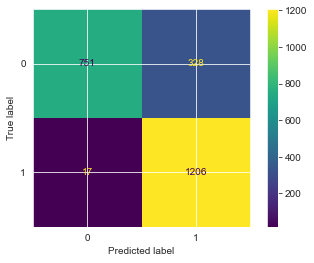

In [26]:
best_classifier = test_best(DecisionTreeClassifier, tr, ts, tr_target, ts_target, out_dir+'DecisionTreeClassifier', results_df=results_df)

In [29]:
dot_data = export_graphviz(best_classifier, out_file=None, feature_names=list(ts.columns), filled=True, rounded=True,
                           class_names=['genuine user', 'bot'])
graph = pydotplus.graph_from_dot_data(dot_data)
with open(out_dir+'decision_tree/dtree_graph.png', 'wb') as png:
    png.write(Image(graph.create_png()).data)

Chosen columns of SelectKBest: Index(['statuses_count', 'n_tweets', '2018_tweets', '2019_tweets',
       '2020_tweets', 'publication_date_in_secs_std', 'retweet_count_std',
       'retweet_count_sum', 'num_hashtags_mean', 'num_hashtags_sum',
       'num_urls_std', 'num_mentions_mean', 'num_mentions_std',
       'tweeting_regularity', 'max_daily_tweets'],
      dtype='object')
Fitting 4 folds for each of 2880 candidates, totalling 11520 fits


C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3840 fits failed out of a total of 11520.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3840 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed_message

Best combo:
	params: {'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 16, 'random_state': 42, 'splitter': 'best'}
	mean_train_accuracy: 0.8597653775414226
	mean_train_recall: 0.9923019510249733
	mean_train_precision: 0.7948279807242365
	mean_train_f1: 0.8826542625731914
	mean_val_accuracy: 0.8599827314154576
	mean_val_recall: 0.9924383012948979
	mean_val_precision: 0.7950281295798927
	mean_val_f1: 0.8828298745235377

Test set metrics: 
Accuracy 0.8514335360556038
Precision test set  0.8780460698550717
Recall test set  0.8514335360556038
F1 score test set  0.8472355024187456
Support test set  (array([0.98169935, 0.78659727]), array([0.69601483, 0.98855274]), array([0.81453362, 0.87608696]), array([1079, 1223], dtype=int64))
              precision    recall  f1-score   support

genuine_user       0.98      0.70      0.81      1079
         bot       0.79      0.99      0.88      

C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3840 fits failed out of a total of 11520.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3840 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed_message

Best combo:
	params: {'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
	mean_train_accuracy: 0.8597653775414226
	mean_train_recall: 0.9923019510249732
	mean_train_precision: 0.7948277639707649
	mean_train_f1: 0.8826542538978935
	mean_val_accuracy: 0.8598740830017244
	mean_val_recall: 0.9924383012948979
	mean_val_precision: 0.7948993859917115
	mean_val_f1: 0.8827499501899962

Test set metrics: 
Accuracy 0.8514335360556038
Precision test set  0.8780460698550717
Recall test set  0.8514335360556038
F1 score test set  0.8472355024187456
Support test set  (array([0.98169935, 0.78659727]), array([0.69601483, 0.98855274]), array([0.81453362, 0.87608696]), array([1079, 1223], dtype=int64))
              precision    recall  f1-score   support

genuine_user       0.98      0.70      0.81      1079
         bot       0.79      0.99      0.88      1

C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3840 fits failed out of a total of 11520.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3840 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed_message

Best combo:
	params: {'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 32, 'random_state': 42, 'splitter': 'best'}
	mean_train_accuracy: 0.8597653775414226
	mean_train_recall: 0.9924381908069896
	mean_train_precision: 0.794763405918028
	mean_train_f1: 0.88266850550571
	mean_val_accuracy: 0.8597654345879913
	mean_val_recall: 0.9924383012948979
	mean_val_precision: 0.7947692031056501
	mean_val_f1: 0.882669648811985

Test set metrics: 
Accuracy 0.8505647263249348
Precision test set  0.8774805036762707
Recall test set  0.8505647263249348
F1 score test set  0.8462951504339244
Support test set  (array([0.98165138, 0.78557505]), array([0.69416126, 0.98855274]), array([0.81324647, 0.87545257]), array([1079, 1223], dtype=int64))
              precision    recall  f1-score   support

genuine_user       0.98      0.69      0.81      1079
         bot       0.79      0.99      0.88      1223

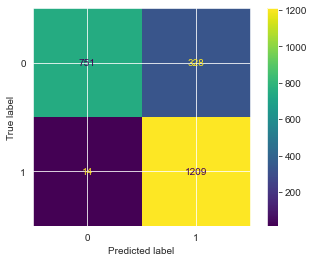

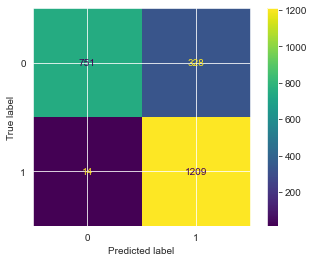

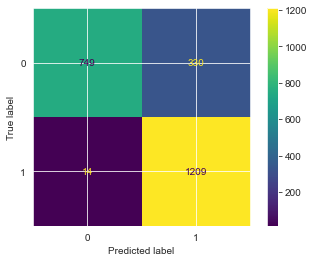

In [32]:
grid_search_with_feature_selection(DecisionTreeClassifier, parameters, 'decision_tree', tr, ts, tr_target, ts_target, n_jobs=5,
                                   folds=4, n_features=15)

# Naive Bayes

In [33]:
labels = ['genuine user','bot']
parameters = {
    'alpha':[0.25,0.5,0.75,1, 2, 10, 1e2, 1e4],
    'fit_prior': [True, False]
}

In [35]:
nb_out_dir = 'mn_naive_bayes'
try:
    os.mkdir(out_dir+nb_out_dir)
except FileExistsError:
    pass

Chosen columns of SelectKBest: Index(['statuses_count', 'user_subscription_in_secs', 'n_tweets',
       '2015_tweets', '2016_tweets', '2017_tweets', '2018_tweets',
       '2019_tweets', '2020_tweets', 'publication_date_in_secs_std',
       'retweet_count_std', 'retweet_count_sum', 'reply_count_entropy',
       'favorite_count_mean', 'favorite_count_std', 'num_hashtags_mean',
       'num_hashtags_std', 'num_hashtags_sum', 'num_urls_mean', 'num_urls_std',
       'num_urls_sum', 'num_mentions_mean', 'num_mentions_std',
       'tweeting_regularity', 'max_daily_tweets'],
      dtype='object')
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Best combo:
	params: {'alpha': 0.25, 'fit_prior': False}
	mean_train_accuracy: 0.8105944627593654
	mean_train_recall: 0.9734995985957908
	mean_train_precision: 0.7469203271105075
	mean_train_f1: 0.8452885896905857
	mean_val_accuracy: 0.8116435795867093
	mean_val_recall: 0.9742495083342686
	mean_val_precision: 0.747774062680267
	mean_val_f1: 0

TypeError: cannot unpack non-iterable NoneType object

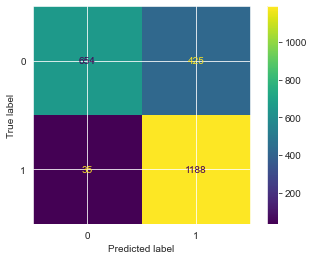

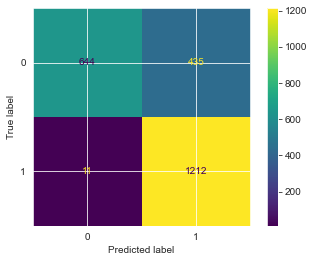

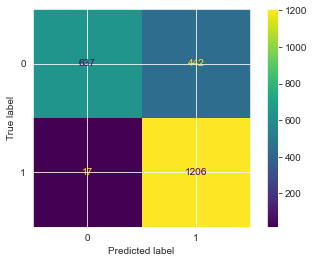

In [36]:
grid_search_with_feature_selection(MultinomialNB, parameters, nb_out_dir, tr, ts, tr_target, ts_target)

# Adaboost

In [19]:
# TODO add random state to make replicable grid?
parameters = {
    'base_estimator': [DecisionTreeClassifier(max_depth=4), DecisionTreeClassifier(max_depth=4, min_samples_split=2, criterion='gini', min_impurity_decrease=0.0, min_samples_leaf=8, splitter='best'), SVC(C=10000, gamma='auto', kernel='rbf', tol=0.1)],
    'n_estimators': [4,8,16,32,64,128,256],
    'learning_rate': [1e-3,1e-2, 1e-1, 1, 1e1, 1e2],
    'algorithm': ['SAMME']#,'SAMME.R'],
}

In [20]:
results_df = grid_search(AdaBoostClassifier, parameters, 'adaboost', tr, tr_target)

Fitting 4 folds for each of 126 candidates, totalling 504 fits


KeyboardInterrupt: 

# Random Forest

In [61]:
parameters = {
    "n_estimators": range(50,500,100),
    "criterion": ["gini","entropy","log_loss"],
    "max_depth": [None] + list(range(5,100,10)),
    "min_samples_split": [2,4,8,16,32,64],
    "min_samples_leaf": [2,4,8,16,32,64,128],
    "max_features":["auto","sqrt","log2",None],
    "max_leaf_nodes":[None] + list(range(1,10,2)),
    "min_impurity_decrease": 0.1 * np.array(range(1,5))
}

'  \n"max_depth": [None] + list(range(5,100,10)),\n    #"min_samples_split": [2,4,8,16,32,64],\n    "min_samples_split": [2,16,64],\n    #"min_samples_leaf": [2,4,8,16,32,64,128],\n    "min_samples_leaf": [2,16,64,128],\n    "max_features":["auto","sqrt","log2",None],\n    "max_leaf_nodes":[None] + list(range(1,10,2)),\n    "min_impurity_decrease": 0.1 * np.array(range(1,5))\n'

In [63]:
rf, results_df = grid_search(RandomForestClassifier, parameters, 'random_forest', tr, ts, tr_target, ts_target)

In [13]:
best_params = {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': 9, 'min_impurity_decrease': 0.2, 'min_samples_leaf': 8, 'min_samples_split': 32, 'n_estimators': 50}

Accuracy 0.8266724587315378
Precision test set  0.8693097515589832
Recall test set  0.8266724587315378
F1 score test set  0.8191684696842777
Support test set  (array([1.       , 0.7540074]), array([0.63021316, 1.        ]), array([0.77316657, 0.85975395]), array([1079, 1223], dtype=int64))
              precision    recall  f1-score   support

genuine_user       1.00      0.63      0.77      1079
         bot       0.75      1.00      0.86      1223

    accuracy                           0.83      2302
   macro avg       0.88      0.82      0.82      2302
weighted avg       0.87      0.83      0.82      2302



RandomForestClassifier(max_depth=15, max_features='sqrt', max_leaf_nodes=9,
                       min_impurity_decrease=0.2, min_samples_leaf=8,
                       min_samples_split=32, n_estimators=50)

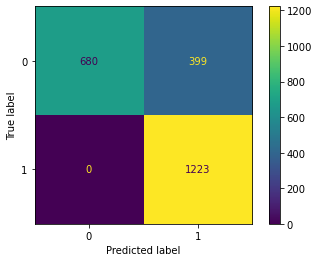

In [14]:
test_best(RandomForestClassifier, best_params, tr, ts, tr_target, ts_target, 'classification/random_forest/')

# SVM

In [37]:
parameters_linear = {
    'C': [10**(exp) for exp in [-2,-1,1,2,3,4]],
    'kernel': ['linear'],
    'random_state': [42]
}

gamma_range = ['scale','auto'] + [10**(exp) for exp in [-2,-1,0]]

parameters_poly = {
    **parameters_linear,
    'kernel': ['poly'],
    'degree': list(range(2,8)),
    'gamma': gamma_range,
}

parameters_rbf = {
    **parameters_linear,
    'kernel': ['rbf'],
    'gamma': gamma_range
}

In [ ]:
results_df = grid_search(SVC, [parameters_rbf, parameters_linear, parameters_poly], 'svm_all_kernels',tr, tr_target, n_jobs=6)

Fitting 4 folds for each of 216 candidates, totalling 864 fits


In [27]:
results_df = pd.read_csv('classification/svm/gs_results.csv')

In [31]:
results_df.sort_values(by='mean_test_f1', ascending=False)[['params','mean_test_f1']]

,params,mean_test_f1
36,"{'C': 10000, 'gamma': 'auto', 'kernel': 'rbf',...",0.857578
38,"{'C': 10000, 'gamma': 0.1, 'kernel': 'rbf', 'r...",0.857453
31,"{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf', 'ra...",0.856775
29,"{'C': 1000, 'gamma': 'auto', 'kernel': 'rbf', ...",0.856246
37,"{'C': 10000, 'gamma': 0.01, 'kernel': 'rbf', '...",0.856201
25,"{'C': 100, 'gamma': 1, 'kernel': 'rbf', 'rando...",0.855638
21,"{'C': 100, 'gamma': 'scale', 'kernel': 'rbf', ...",0.855435
32,"{'C': 1000, 'gamma': 1, 'kernel': 'rbf', 'rand...",0.854879
28,"{'C': 1000, 'gamma': 'scale', 'kernel': 'rbf',...",0.854550
14,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf', '...",0.854206


In [ ]:
best_classifier, results_df = grid_search(SVC, parameters_poly, 'poly_svm', tr, ts, tr_target, ts_target, n_jobs=6)

Fitting 4 folds for each of 294 candidates, totalling 1176 fits


# NN

In [15]:
from keras.models import Model
input_layer = InputLayer(tr[0].shape, batch_size=64)
dense_layer = Dense(units=4, activation='sigmoid')(input_layer)
dense_layer = Dense(units=4, activation='sigmoid')(dense_layer)
out_layer = Softmax()(dense_layer)

model = Model(inputs=input_layer, outputs=out_layer)

model.compile(loss='binary_crossentropy', metrics=['precision','recall','accuracy','f1'])
model.fit(tr, tr_target, validation_split=0.2, epochs=3, workers=6)

ModuleNotFoundError: No module named 'tensorflow'

# Feature selection